Object Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
from PIL import Image, ImageColor, ImageDraw, ImageFont
import time
import os

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
print(os.listdir("../input"))

['open-images-2019-object-detection']


In [3]:
print(os.listdir("../input/open-images-2019-object-detection"))

['sample_submission.csv', 'test']


In [4]:
DIR_PATH = '../input/open-images-2019-object-detection/'

In [5]:
all_image_paths = list(map(lambda x: DIR_PATH+'test/'+x, os.listdir(DIR_PATH+'test/')))
all_image_ids   = list(path.split(DIR_PATH+'test/')[1][:-4] for path in all_image_paths)

In [6]:
print('len(all_image_paths):', len(all_image_paths))
print('len(all_image_ids)  :', len(all_image_ids))

len(all_image_paths): 99999
len(all_image_ids)  : 99999


In [7]:
print('\n'.join(all_image_paths[:5]))

../input/open-images-2019-object-detection/test/15fe48f0b21740d2.jpg
../input/open-images-2019-object-detection/test/1e0efd102f2c709c.jpg
../input/open-images-2019-object-detection/test/37c7cab80d9d1277.jpg
../input/open-images-2019-object-detection/test/1e97ba8811bdc541.jpg
../input/open-images-2019-object-detection/test/97889265307d0ca7.jpg


In [8]:
print('\n'.join(all_image_ids[:5]))

15fe48f0b21740d2
1e0efd102f2c709c
37c7cab80d9d1277
1e97ba8811bdc541
97889265307d0ca7


In [9]:
def show_image(i):
    plt.imshow(Image.open(all_image_paths[i]))

In [10]:
def get_prediction_string(res):
    with tf.device('/device:GPU:0'):
        pred_strs = []
        for i, score in enumerate(res['detection_scores']):
            single_pred_str = ''
            single_pred_str += res['detection_class_names'][i].decode("utf-8") + ' ' + str(score) + ' '
            single_pred_str += ' '.join(str(x) for x in res['detection_boxes'][i])
            pred_strs.append(single_pred_str)
        return ' '.join(map(str, pred_strs))

In [11]:
def get_prediction_entry(i, res):
    return {
        "ImageID": all_image_ids[i],
        "PredictionString": get_prediction_string(res)
    }

In [12]:
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: 


In [13]:
tf.version

<module 'tensorflow.compat.v1.version' from '/opt/conda/lib/python3.7/site-packages/tensorflow/_api/v2/compat/v1/version/__init__.py'>

In [14]:
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import merge
from keras.models import Model

In [15]:
def generate_layers(n_layers, filters, kernel, stride, bnorm, leaky, idx):
    layers = []
    for i in range(n_layers):
        layers += [{'filter': filters[i], 'kernel': kernel[i], 'stride': stride[i], 
                    'bnorm': bnorm[i], 'leaky': leaky[i], 'idx': idx[i]}]
    return layers

In [16]:
def constract_neural_network():
    neural_network_layers = {
         0: generate_layers(n_layers=4, filters=[32,64,32,64],  kernel=[3,3,1,3],   stride=[1,2,1,1], 
                                        bnorm=[1,1,1,1],        leaky=[1,1,1,1],    idx=[0,1,2,3]),
         1: generate_layers(n_layers=3, filters=[128,64,128],   kernel=[3,1,3],     stride=[2,1,1], 
                                        bnorm=[1,1,1],          leaky=[1,1,1],      idx=[5,6,7]),
         2: generate_layers(n_layers=2, filters=[64,128],       kernel=[1,3],       stride=[1,1], 
                                        bnorm=[1,1],            leaky=[1,1],        idx=[9,10]),
         3: generate_layers(n_layers=3, filters=[256,128,256],  kernel=[3,1,3],     stride=[2,1,1], 
                                        bnorm=[1,1,1],          leaky=[1,1,1],      idx=[12,13,14]),
         4: generate_layers(n_layers=2, filters=[128,256],      kernel=[1,3],       stride=[1,1], 
                                        bnorm=[1,1],            leaky=[1,1],        idx=[16+i*3, 17+i*3]),
         5: generate_layers(n_layers=3, filters=[512,256,512],  kernel=[3,1,3],     stride=[2,1,1], 
                                        bnorm=[1,1,1],          leaky=[1,1,1],      idx=[37,38,39]),
         6: generate_layers(n_layers=2, filters=[256,512],      kernel=[1,3],       stride=[1,1], 
                                        bnorm=[1,1],            leaky=[1,1],        idx=[41+i*3, 42+i*3]),
         7: generate_layers(n_layers=3, filters=[1024,512,1024], kernel=[3,1,3],    stride=[2,1,1], 
                                        bnorm=[1,1,1],          leaky=[1,1,1],      idx=[62,63,64]),
         8: generate_layers(n_layers=2, filters=[512,1024],     kernel=[1,3],       stride=[1,1], 
                                        bnorm=[1,1],            leaky=[1,1],        idx=[66+i*3, 67+i*3]),
         9: generate_layers(n_layers=5, filters=[512,1024,512,1024,512], 
                                        kernel=[1,3,1,3,1],                         stride=[1,1,1,1,1], 
                                        bnorm=[1,1,1,1,1],      leaky=[1,1,1,1,1],  idx=[75,76,77,78,79]),
        10: generate_layers(n_layers=2, filters=[1024,255],     kernel=[3,1],       stride=[1,1], 
                                        bnorm=[1,0],            leaky=[1,0],        idx=[80,81]),
        11: generate_layers(n_layers=1, filters=[256],          kernel=[1],         stride=[1], 
                                        bnorm=[1],              leaky=[1],          idx=[84]),
        12: generate_layers(n_layers=5, filters=[256,512,256,512,256], 
                                        kernel=[1,3,1,3,1],                         stride=[1,1,1,1,1], 
                                        bnorm=[1,1,1,1,1],      leaky=[1,1,1,1,1],  idx=[87,88,89,90,91]),
        13: generate_layers(n_layers=2, filters=[512,255],      kernel=[3,1],       stride=[1,1], 
                                        bnorm=[1,0],            leaky=[1,0],        idx=[92,93]),
        14: generate_layers(n_layers=1, filters=[128],          kernel=[1],         stride=[1], 
                                        bnorm=[1],              leaky=[1],          idx=[96]),
        15: generate_layers(n_layers=7, filters=[128,256,128,256,128,256,255], 
                                        kernel=[1,3,1,3,1,3,1],                     stride=[1,1,1,1,1,1,1], 
                                        bnorm=[1,1,1,1,1,1,0],  leaky=[1,1,1,1,1,1,0], 
                                        idx=[99,100,101,102,103,104,105]),
    }
    return neural_network_layers

In [17]:
def conv_block(x, layers, skip=True):
    for i in range(len(layers)):
        if skip and i == len(layers) - 2:
            skip_conn = x
        if layers[i]['stride'] > 1: 
            x = ZeroPadding2D(((1,0), (1,0)))(x)
        layer_name = 'conv_' + str(layers[i]['idx'])
        x = Conv2D(layers[i]['filter'], layers[i]['kernel'],
                   strides=conv['stride'],
                   padding=('valid' if layers[i]['stride'] > 1 else 'same'), 
                   name=layer_name,
                   use_bias=(not layers[i]['bnorm']))(x)
        if layers[i]['bnorm']: 
            layer_name = 'bnorm_' + str(layers[i]['idx'])
            x = BatchNormalization(epsilon=0.001, name=layer_name)(x)
        if layers[i]['leaky']: 
            layer_name = 'leaky_' + str(layers[i]['idx'])
            x = LeakyReLU(alpha=0.1, name=layer_name)(x)
    return x if not skip else merge.add([skip_conn, x])

In [18]:
def constract_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    neural_network_layers = constract_neural_network()
    x = conv_block(input_image, neural_network_layers[0])   # Layer  0 to  4
    x = conv_block(x, neural_network_layers[1])             # Layer  5 to  8
    x = conv_block(x, neural_network_layers[2])             # Layer  9 to 11
    x = conv_block(x, neural_network_layers[3])             # Layer 12 to 15
    for i in range(7):                                      # Layer 16 to 36
        x = conv_block(x, neural_network_layers[4])
    skip_36 = x
    x = conv_block(x, neural_network_layers[5])         # Layer 37 to 40
    for i in range(7):                                  # Layer 41 to 61
        x = conv_block(x, neural_network_layers[6])
    skip_61 = x
    x = conv_block(x, neural_network_layers[7])         # Layer 62 to 65
    for i in range(3):                                  # Layer 66 to 74
        x = conv_block(x, neural_network_layers[8])
    x = conv_block(x, neural_network_layers[9], skip=False)         # Layer 75 to 79
    yolo_82 = conv_block(x, neural_network_layers[10], skip=False)  # Layer 80 to 82
    x = conv_block(x, neural_network_layers[11], skip=False)        # Layer 83 to 86
    x = UpSampling2D(2)(x)
    x = merge.concatenate([x, skip_61])
    x = conv_block(x, neural_network_layers[12], skip=False)        # Layer 87 to 91
    yolo_94 = conv_block(x, neural_network_layers[13], skip=False)  # Layer 92 to 94
    x = conv_block(x, neural_network_layers[14], skip=False)        # Layer 95 to 98
    x = UpSampling2D(2)(x)
    x = merge.concatenate([x, skip_36])
    yolo_106 = conv_block(x, neural_network_layers[15], skip=False) # Layer 99 to 106
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

In [19]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    draw = ImageDraw.Draw(image)
    w, h = image.size
    (left, right) = (xmin * w, xmax * w)
    (top, bottom) = (ymin * h, ymax * h)
    line_points = [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)]
    draw.line(line_points, width=thickness, fill=color)
    display_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_height = (1 + 2 * 0.05) * sum(display_heights)
    text_bottom = top if top > total_display_height else bottom + total_display_height

    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        rect_points = [(left, text_bottom - text_height - 2 * margin), 
                       (left + text_width, text_bottom)]
        draw.rectangle(rect_points, fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin

In [20]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] < min_score:
            continue
        ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
        display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
        color = colors[hash(class_names[i]) % len(colors)]
        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
        draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax,
                                   color, font, display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
    return image

In [21]:
def detect_objects(i, predictions=[]):
    module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

    with tf.device('/device:GPU:0'):
        with tf.Graph().as_default():
            detector = hub.Module(module_handle)
            image_string_placeholder = tf.placeholder(tf.string)
            decoded_image = tf.image.decode_jpeg(image_string_placeholder)
            decoded_image_float = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
            module_input = tf.expand_dims(decoded_image_float, 0)
            res = detector(module_input, as_dict=True)
            init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]
            session = tf.Session()
            session.run(init_ops)
            
            with tf.gfile.Open(all_image_paths[i], "rb") as binfile:
                image_string = binfile.read()
            inference_start_time = time.clock()
            res_out, image_out = session.run([res, decoded_image],
                                             feed_dict={image_string_placeholder: image_string})
            inference_end_time = time.clock()
            predictions.append(get_prediction_entry(i, res_out))
            print('For %s found %d objects in %d seconds' % (all_image_paths[i].split('/')[-1], 
                                                             len(res_out["detection_scores"]), 
                                                             int(inference_end_time - inference_start_time)))
            return res_out, image_out, predictions

In [22]:
def detect_objects_in_image(i):
    res_out, image_out, predictions = detect_objects(i)
    image_out = np.array(image_out)
    image_with_boxes = draw_boxes(image_out,
                                  res_out["detection_boxes"],
                                  res_out["detection_class_entities"], 
                                  res_out["detection_scores"])
    img = Image.fromarray(np.uint8(image_with_boxes)).convert('RGB')
    plt.imshow(img)

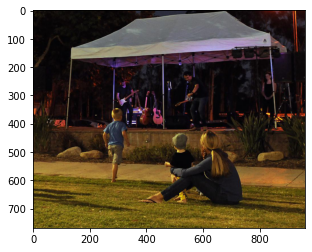

In [23]:
show_image(0)

2022-09-30 15:31:17.717837: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-30 15:31:49.543365: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { k

For 15fe48f0b21740d2.jpg found 100 objects in 125 seconds


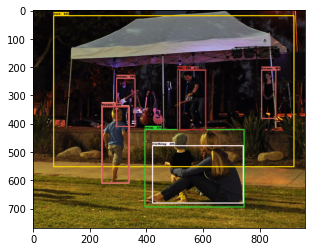

In [24]:
detect_objects_in_image(0)

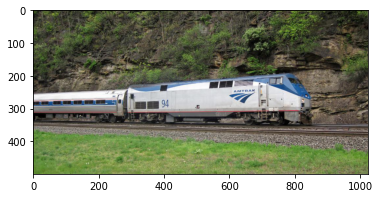

In [25]:
show_image(1)

2022-09-30 15:34:32.361999: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 1e0efd102f2c709c.jpg found 100 objects in 143 seconds


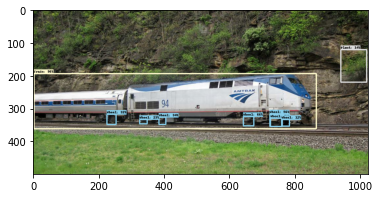

In [26]:
detect_objects_in_image(1)

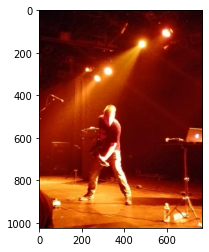

In [27]:
show_image(2)

2022-09-30 15:37:26.059872: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 37c7cab80d9d1277.jpg found 100 objects in 138 seconds


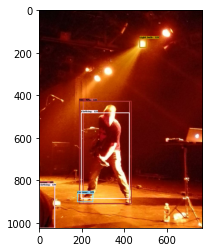

In [28]:
detect_objects_in_image(2)

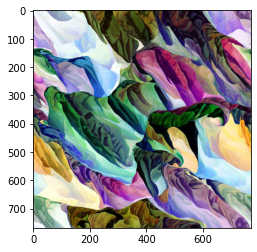

In [29]:
show_image(3)

2022-09-30 15:39:54.749868: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 1e97ba8811bdc541.jpg found 100 objects in 122 seconds


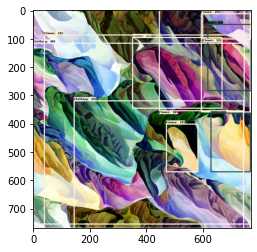

In [30]:
detect_objects_in_image(3)

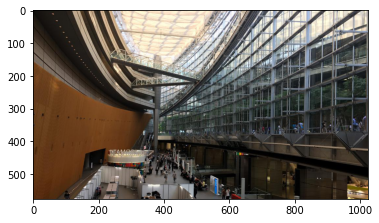

In [31]:
show_image(4)

2022-09-30 15:42:38.071087: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 97889265307d0ca7.jpg found 100 objects in 154 seconds


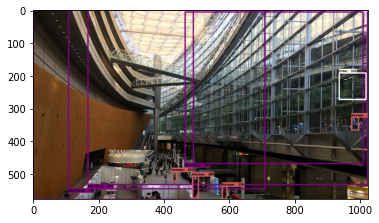

In [32]:
detect_objects_in_image(4)

In [33]:
predictions = []
for i in range(10):
    detect_objects(i, predictions)

2022-09-30 15:45:50.970163: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 15fe48f0b21740d2.jpg found 100 objects in 159 seconds


2022-09-30 15:48:58.796081: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 1e0efd102f2c709c.jpg found 100 objects in 142 seconds


2022-09-30 15:51:51.827803: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 37c7cab80d9d1277.jpg found 100 objects in 141 seconds


2022-09-30 15:54:50.310254: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 1e97ba8811bdc541.jpg found 100 objects in 146 seconds


2022-09-30 15:57:30.042166: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 97889265307d0ca7.jpg found 100 objects in 127 seconds


2022-09-30 15:59:53.031256: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For fb0a2e73595776af.jpg found 100 objects in 126 seconds


2022-09-30 16:02:17.228382: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For b15ff5fb76f10af0.jpg found 100 objects in 120 seconds


2022-09-30 16:04:41.313784: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 1ef2e680ca86d3ce.jpg found 100 objects in 125 seconds


2022-09-30 16:07:04.270145: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 11b642a20ccace2e.jpg found 100 objects in 126 seconds


2022-09-30 16:09:27.909209: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2485 } dim { size: -2486 } dim { size: -2487 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\021\000\000\000\021\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2199 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size

For 0f69e5fe241a49af.jpg found 100 objects in 124 seconds


In [34]:
predictions_df = pd.DataFrame(predictions)
predictions_df

,ImageID,PredictionString
0,15fe48f0b21740d2,/m/01j61q 0.8266561 0.026195705 0.075309485 0....
1,1e0efd102f2c709c,/m/07jdr 0.9619753 0.38868183 0.0026356578 0.7...
2,37c7cab80d9d1277,/m/01g317 0.63306147 0.41916445 0.26941347 0.8...
3,1e97ba8811bdc541,/m/09j2d 0.36104113 0.15322536 0.0 0.9808069 1...
4,97889265307d0ca7,/m/0cgh4 0.9581952 0.0 0.16345969 0.92233616 0...
5,fb0a2e73595776af,/m/04yx4 0.70600873 0.0831128 0.1823073 0.4048...
6,b15ff5fb76f10af0,/m/09j5n 0.9769568 0.48077893 0.26656803 0.765...
7,1ef2e680ca86d3ce,/m/0dzct 0.95266503 0.2547487 0.20416792 0.874...
8,11b642a20ccace2e,/m/0dzct 0.6751655 0.2694856 0.8250332 0.37811...
9,0f69e5fe241a49af,/m/07j7r 0.715867 0.0 0.013628134 1.0 0.935594...


In [35]:
submission_df = pd.read_csv(DIR_PATH+'sample_submission.csv')
submission_df.update(predictions_df)

In [36]:
submission_df.to_csv('./10_values_submission.csv', index=False)